In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from numba import njit

@njit
def simulate_one_run(params):
    beta = params["beta"]
    a = params["a"]       # assortativity in [-1, 1]
    sigma = params["sigma"]
    gamma = params["gamma"]
    beta_multiplier = params["beta_multiplier"]
    cross_immunity = params["cross_immunity"]
    p_mutation = params["p_mutation"]  # Probability that strain 1 mutates upon transmission

    # Simulation parameters
    N = 2000                  
    frac_vaccinated = 0.7     
    contacts_per_infected = 1  
    dt = 0.2
    timesteps = int(100/dt)    

    # State labels:
    # 0: Susceptible
    # 1: Infected with strain 1
    # 2: Vaccinated
    # 3: Infected with strain 2
    # 4: Recovered from strain 2
    # 5: Recovered from strain 1
    # 6: Recovered from both strains
    vaccinated = np.random.rand(N) < frac_vaccinated
    state = np.zeros(N, dtype=np.int64)  
    had_strain1 = np.zeros(N, dtype=np.bool_)
    had_strain2 = np.zeros(N, dtype=np.bool_)

    state[vaccinated] = 2  

    unvaccinated_indices = np.where(~vaccinated)[0]
    if len(unvaccinated_indices) > 0:
        initial_infected_idx1 = np.random.randint(0, len(unvaccinated_indices))
        initial_infected_strain1 = unvaccinated_indices[initial_infected_idx1]
        state[initial_infected_strain1] = 1
        had_strain1[initial_infected_strain1] = True

    I1_history = np.zeros(timesteps, dtype=np.int64)
    I2_history = np.zeros(timesteps, dtype=np.int64)

    for t in range(timesteps):
        new_state = state.copy()
        
        infected_strain1_indices = np.where(state == 1)[0]
        
        for i in infected_strain1_indices:
            v_status = vaccinated[i]
            f_same = np.sum(vaccinated == v_status) / N
            p_same = f_same + a * (1 - f_same) if a >= 0 else f_same + a * f_same

            for _ in range(contacts_per_infected):
                candidates = np.where(vaccinated == v_status)[0] if random.random() < p_same else np.where(vaccinated != v_status)[0]
                candidates = candidates[candidates != i]
                if len(candidates) == 0:
                    continue

                contact_idx = np.random.randint(0, len(candidates))
                contact = candidates[contact_idx]

                trans_prob = beta * dt
                if state[contact] in {0, 3, 4} and random.random() < trans_prob:
                    if state[contact] != 3:  
                        if random.random() < p_mutation:  # Mutation event
                            new_state[contact] = 3  
                            had_strain2[contact] = True
                        else:
                            new_state[contact] = 1  
                            had_strain1[contact] = True
                elif state[contact] == 2:
                    effective_beta = (1.0 - sigma) * beta if vaccinated[contact] else beta
                    if random.random() < effective_beta * dt:
                        if random.random() < p_mutation:
                            new_state[contact] = 3  
                            had_strain2[contact] = True
                        else:
                            new_state[contact] = 1  
                            had_strain1[contact] = True

        infected_strain2_indices = np.where(state == 3)[0]

        for i in infected_strain2_indices:
            v_status = vaccinated[i]
            f_same = np.sum(vaccinated == v_status) / N
            p_same = f_same + a * (1 - f_same) if a >= 0 else f_same + a * f_same

            for _ in range(contacts_per_infected):
                candidates = np.where(vaccinated == v_status)[0] if random.random() < p_same else np.where(vaccinated != v_status)[0]
                candidates = candidates[candidates != i]
                if len(candidates) == 0:
                    continue

                contact_idx = np.random.randint(0, len(candidates))
                contact = candidates[contact_idx]

                beta2 = beta * beta_multiplier  
                immunity_factor = 1.0 if not had_strain1[contact] else (1.0 - cross_immunity)
                
                trans_prob = beta2 * dt * immunity_factor
                if state[contact] in {0, 1, 2} and random.random() < trans_prob:
                    if state[contact] != 1:  
                        new_state[contact] = 3
                        had_strain2[contact] = True
                elif state[contact] == 4:
                    effective_beta = (1.0 - sigma) * beta2 * immunity_factor
                    if random.random() < effective_beta * dt:
                        new_state[contact] = 3
                        had_strain2[contact] = True

        for i in infected_strain1_indices:
            if random.random() < gamma * dt:
                new_state[i] = 5 if had_strain2[i] else 2

        for i in infected_strain2_indices:
            if random.random() < gamma * dt:
                new_state[i] = 5 if had_strain1[i] else 4

        state = new_state.copy()
        I1_history[t] = np.sum(state == 1)
        I2_history[t] = np.sum(state == 3)

    peak_infected_strain1 = np.max(I1_history)
    peak_infected_strain2 = np.max(I2_history)
    outbreak_strain1 = peak_infected_strain1 >= 20
    outbreak_strain2 = peak_infected_strain2 >= 20
    any_outbreak = outbreak_strain1 or outbreak_strain2
    both_outbreaks = outbreak_strain1 and outbreak_strain2
    
    return peak_infected_strain1, peak_infected_strain2, outbreak_strain1, outbreak_strain2, any_outbreak, both_outbreaks


def run_simulations_for_beta(params, num_simulations=200, max_workers=20):
    """
    Runs multiple simulation realizations in parallel for a given beta.
    Returns:
        results (list of tuples): Each tuple contains outbreak information for both strains.
    """
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(simulate_one_run, params) for _ in range(num_simulations)]
        for future in as_completed(futures):
            results.append(future.result())
    return results

# Create parameter dictionary
param_dtype = np.dtype([
    ('beta', np.float64),
    ('a', np.float64),
    ('sigma', np.float64),
    ('gamma', np.float64),
    ('beta_multiplier', np.float64),
    ('cross_immunity', np.float64),
    ('p_mutation', np.float64)  
])

params = np.zeros(1, dtype=param_dtype)[0]
params["beta"] = 0.0
params["a"] = 0.0
params["sigma"] = 0.999
params["gamma"] = 0.2
params["beta_multiplier"] = 1.0  
params["cross_immunity"] = 0.5  
params["p_mutation"] = 0.01  



# Define the range of beta values
betas = np.arange(0, 2.51, 0.1)

# For high assortativity
asso_1 = 0.99
# For low assortativity
asso_2 = 0.00

# Arrays to store results
outbreak_prob_strain1_high_asso = []
outbreak_prob_strain2_high_asso = []
outbreak_prob_any_high_asso = []
outbreak_prob_both_high_asso = []

# Set parameters for high assortativity
params["a"] = asso_1

# Loop over each beta value with high assortativity
for beta in betas:
    params['beta'] = beta
    results = run_simulations_for_beta(params, num_simulations=200, max_workers=25)
    
    # Extract results for each strain
    outbreak_flags_strain1 = [res[2] for res in results]  # Index 2 is outbreak_strain1
    outbreak_flags_strain2 = [res[3] for res in results]  # Index 3 is outbreak_strain2
    outbreak_flags_any = [res[4] for res in results]      # Index 4 is any_outbreak
    outbreak_flags_both = [res[5] for res in results]     # Index 5 is both_outbreaks
    
    # Calculate probabilities
    prob_strain1 = sum(outbreak_flags_strain1) / len(outbreak_flags_strain1)
    prob_strain2 = sum(outbreak_flags_strain2) / len(outbreak_flags_strain2)
    prob_any = sum(outbreak_flags_any) / len(outbreak_flags_any)
    prob_both = sum(outbreak_flags_both) / len(outbreak_flags_both)
    
    # Store results
    outbreak_prob_strain1_high_asso.append(prob_strain1)
    outbreak_prob_strain2_high_asso.append(prob_strain2)
    outbreak_prob_any_high_asso.append(prob_any)
    outbreak_prob_both_high_asso.append(prob_both)
    
    print(f"High Assortativity (a={asso_1}), Beta = {beta:.2f}:")
    print(f"  Strain 1 outbreak probability: {prob_strain1:.3f}")
    print(f"  Strain 2 outbreak probability: {prob_strain2:.3f}")
    print(f"  Any strain outbreak probability: {prob_any:.3f}")
    print(f"  Both strains outbreak probability: {prob_both:.3f}")

# Arrays to store results for low assortativity
outbreak_prob_strain1_low_asso = []
outbreak_prob_strain2_low_asso = []
outbreak_prob_any_low_asso = []
outbreak_prob_both_low_asso = []

# Set parameters for low assortativity
params["a"] = asso_2

# Loop over each beta value with low assortativity
for beta in betas:
    params['beta'] = beta
    results = run_simulations_for_beta(params, num_simulations=200, max_workers=25)
    
    # Extract results for each strain
    outbreak_flags_strain1 = [res[2] for res in results]
    outbreak_flags_strain2 = [res[3] for res in results]
    outbreak_flags_any = [res[4] for res in results]
    outbreak_flags_both = [res[5] for res in results]
    
    # Calculate probabilities
    prob_strain1 = sum(outbreak_flags_strain1) / len(outbreak_flags_strain1)
    prob_strain2 = sum(outbreak_flags_strain2) / len(outbreak_flags_strain2)
    prob_any = sum(outbreak_flags_any) / len(outbreak_flags_any)
    prob_both = sum(outbreak_flags_both) / len(outbreak_flags_both)
    
    # Store results
    outbreak_prob_strain1_low_asso.append(prob_strain1)
    outbreak_prob_strain2_low_asso.append(prob_strain2)
    outbreak_prob_any_low_asso.append(prob_any)
    outbreak_prob_both_low_asso.append(prob_both)
    
    print(f"Low Assortativity (a={asso_2}), Beta = {beta:.2f}:")
    print(f"  Strain 1 outbreak probability: {prob_strain1:.3f}")
    print(f"  Strain 2 outbreak probability: {prob_strain2:.3f}")
    print(f"  Any strain outbreak probability: {prob_any:.3f}")
    print(f"  Both strains outbreak probability: {prob_both:.3f}")



High Assortativity (a=0.99), Beta = 0.00:
  Strain 1 outbreak probability: 0.000
  Strain 2 outbreak probability: 0.000
  Any strain outbreak probability: 0.000
  Both strains outbreak probability: 0.000
High Assortativity (a=0.99), Beta = 0.10:
  Strain 1 outbreak probability: 0.000
  Strain 2 outbreak probability: 0.000
  Any strain outbreak probability: 0.000
  Both strains outbreak probability: 0.000
High Assortativity (a=0.99), Beta = 0.20:
  Strain 1 outbreak probability: 0.030
  Strain 2 outbreak probability: 0.000
  Any strain outbreak probability: 0.030
  Both strains outbreak probability: 0.000
High Assortativity (a=0.99), Beta = 0.30:
  Strain 1 outbreak probability: 0.310
  Strain 2 outbreak probability: 0.070
  Any strain outbreak probability: 0.320
  Both strains outbreak probability: 0.060
High Assortativity (a=0.99), Beta = 0.40:
  Strain 1 outbreak probability: 0.545
  Strain 2 outbreak probability: 0.290
  Any strain outbreak probability: 0.560
  Both strains outbreak

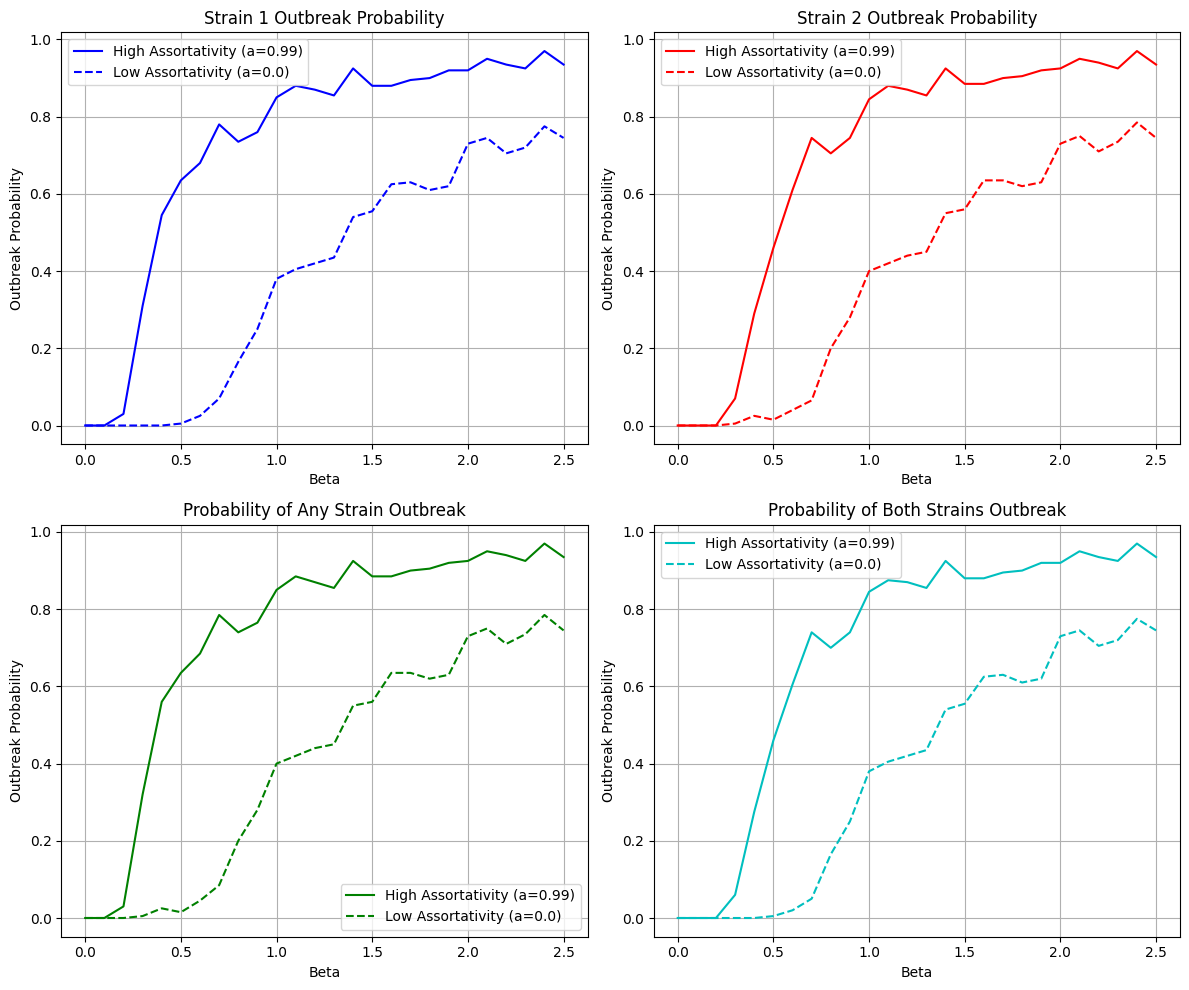

In [9]:
# Optional: Plot the results
plt.figure(figsize=(12, 10))

# Plot for Strain 1
plt.subplot(2, 2, 1)
plt.plot(betas, outbreak_prob_strain1_high_asso, 'b-', label=f'High Assortativity (a={asso_1})')
plt.plot(betas, outbreak_prob_strain1_low_asso, 'b--', label=f'Low Assortativity (a={asso_2})')
plt.xlabel('Beta')
plt.ylabel('Outbreak Probability')
plt.title('Strain 1 Outbreak Probability')
plt.legend()
plt.grid(True)

# Plot for Strain 2
plt.subplot(2, 2, 2)
plt.plot(betas, outbreak_prob_strain2_high_asso, 'r-', label=f'High Assortativity (a={asso_1})')
plt.plot(betas, outbreak_prob_strain2_low_asso, 'r--', label=f'Low Assortativity (a={asso_2})')
plt.xlabel('Beta')
plt.ylabel('Outbreak Probability')
plt.title('Strain 2 Outbreak Probability')
plt.legend()
plt.grid(True)

# Plot for Any Strain Outbreak
plt.subplot(2, 2, 3)
plt.plot(betas, outbreak_prob_any_high_asso, 'g-', label=f'High Assortativity (a={asso_1})')
plt.plot(betas, outbreak_prob_any_low_asso, 'g--', label=f'Low Assortativity (a={asso_2})')
plt.xlabel('Beta')
plt.ylabel('Outbreak Probability')
plt.title('Probability of Any Strain Outbreak')
plt.legend()
plt.grid(True)

# Plot for Both Strains Outbreak
plt.subplot(2, 2, 4)
plt.plot(betas, outbreak_prob_both_high_asso, 'c-', label=f'High Assortativity (a={asso_1})')
plt.plot(betas, outbreak_prob_both_low_asso, 'c--', label=f'Low Assortativity (a={asso_2})')
plt.xlabel('Beta')
plt.ylabel('Outbreak Probability')
plt.title('Probability of Both Strains Outbreak')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('multi_strain_outbreak_probabilities.png')
plt.show()